In [40]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
from pathlib import Path
from sklearn.ensemble import IsolationForest, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.utils import resample
import matplotlib.pyplot as plt


DATA_PATH = '/cluster/home/nteutschm/eqdetection/data/'
DATA_PATH = 'Data/'
RANDOM_STATE = 86
MODEL_TYPE = 'LSTM' # IsolationForest HistGradientBoosting RandomForest
MODEL_PATH = f'/cluster/scratch/nteutschm/eqdetection/models/{MODEL_TYPE}.pkl'
EPOCHS = 40
MODEL_PATH = f'Storage/{MODEL_TYPE}.pkl'
PREDICTIONS_PATH = f'Storage/{MODEL_TYPE}.csv'
PREDICTIONS_PATH = f'/cluster/scratch/nteutschm/eqdetection/predictions/{MODEL_TYPE}.csv'
PREDICTIONS_PATH = f'Storage/{MODEL_TYPE}.csv'


FEATURES_PATH = f'/cluster/scratch/nteutschm/eqdetection/features/{MODEL_TYPE}'
FEATURES_PATH = f'Storage/{MODEL_TYPE}'

LOAD_MODEL = False # If already trained model is saved under MODEL_PATH, it can be loaded if set to True to skip the entire training process

# Optimal parameters:
OPTIMAL_PARAMS = False # If optimal parametrs should be used, or the parameters should be tuned (set to False)

# If OPTIMAL_PARAMS is True, these parameters are used for the training process:
BEST_PARAMS_RANDOM_FOREST = {
    'n_estimators': 100,
    'max_depth': 30,
    'class_weight': {0: 0.5520685260526444, 1: 5.3013650270651915},
    'random_state': RANDOM_STATE
}


# Loading the Data

In [2]:
def get_offsets(header_lines):
    """
    Extracts offset and postseismic decay information from the header lines of a GNSS file.

    The function captures both coseismic and non-coseismic offsets, along with postseismic decays, for 
    north (N), east (E), and up (U) components. It parses lines starting with '#' and collects the relevant 
    values into a structured dictionary categorized by the component.

    Parameters:
    - header_lines (list of str): Lines from the file that contain metadata and comments starting with '#'.

    Returns:
    - components (dict): A dictionary with keys 'n', 'e', and 'u' representing the north, east, and up components.
      Each component holds a dictionary with:
        - 'offsets': A list of dictionaries containing offset information (value, error, date, coseismic flag).
        - 'ps_decays': A list of dictionaries containing postseismic decay information (value, error, tau, date, type).
    """
    
    # Capture important information from the header
    offset_pattern = re.compile(r"#\s*(\*?)\s*offset\s+\d+:?\s+([-\d.]+)\s+\+/\-\s+([-\d.]+)\s+mm.*?\((\d{4}-\d{2}-\d{2}).*?\)")
    ps_decay_pattern = re.compile(r'#!?\s*ps decay\s+\d:\s*(-?\d+\.\d+)\s+\+/-\s+(\d+\.\d+)\s+mm\s+\((\d{4}-\d{2}-\d{2})\s+\[(\d{4}\.\d+)\]\);\s*tau:\s*(\d+)\s+days')
    component_pattern = re.compile(r"#\s+([neu])\s+component")

    components = {'n': {'offsets': [], 'ps_decays': []}, 'e': {'offsets': [], 'ps_decays': []}, 'u': {'offsets': [], 'ps_decays': []}}
    current_component = None

    for line in header_lines:
        comp_match = component_pattern.match(line)
        if comp_match:
            current_component = comp_match.group(1)
            continue

        # Check for offset
        offset_match = offset_pattern.match(line)
        if offset_match and current_component:
            coseismic = bool(offset_match.group(1))  # True if * present, meaning coseismic
            offset_value = float(offset_match.group(2))
            offset_error = float(offset_match.group(3))
            offset_date = offset_match.group(4)
            components[current_component]['offsets'].append({
                'value': offset_value,
                'error': offset_error,
                'date': offset_date,
                'coseismic': coseismic
            })

        # Check for postseismic decay
        ps_decay_match = ps_decay_pattern.match(line)
        if ps_decay_match and current_component:
            decay_value = float(ps_decay_match.group(1))
            decay_error = float(ps_decay_match.group(2))
            decay_date = ps_decay_match.group(3)
            tau = int(ps_decay_match.group(5))
            # Determine decay type based on the presence of '!'
            decay_type = 'logarithmic' if '!' in line else 'exponential'
            components[current_component]['ps_decays'].append({
                'value': decay_value,
                'error': decay_error,
                'tau': tau,
                'date': decay_date,
                'type': decay_type
            })

    return components

def read_file(filename):
    """
    Reads a GNSS file, extracting both header and data information into a pandas DataFrame.

    The function processes the header to extract metadata (e.g., station coordinates, height, offsets, decays) 
    and processes the data section to extract time-series GNSS measurements. It combines these into a DataFrame 
    with attributes containing additional metadata.

    Parameters:
    - filename (str): The path to the file containing GNSS data.

    Returns:
    - data (pandas.DataFrame): A DataFrame containing the time-series GNSS data (N, E, U components, sigmas, correlations),
      indexed by date. The DataFrame has additional attributes storing station geometry (latitude, longitude), height, 
      and offset/decay information.
    """
    
    with open(DATA_PATH+filename, 'r') as file:
        lines = file.readlines()

    header_lines = [line for line in lines if line.startswith('#')]
    if header_lines:
        column_names = re.split(r'\s{2,}', header_lines[-1].lstrip('#').strip())
    else:
        column_names = []
        
    data_lines = []
    for line in lines:
        if not line.startswith('#'):
            parts = line.strip().split()
            # Check if the number of parts matches the expected number of columns
            if len(parts) < len(column_names):
                # Add None for missing values
                parts.extend([None] * (len(column_names) - len(parts)))
            data_lines.append(parts)

    data = pd.DataFrame(data_lines)
    data.columns = column_names
    
    # Extracts latitude, longitude and height
    pattern = r'Latitude\(DD\)\s*:\s*(-?\d+\.\d+)|East Longitude\(DD\)\s*:\s*(-?\d+\.\d+)|Height\s*\(M\)\s*:\s*(-?\d+\.\d+)'
    matches = re.findall(pattern, ' '.join(header_lines))
    geom = Point(float(matches[1][1]), float(matches[0][0]))
    
    offsets = get_offsets(header_lines)

    data['Date'] = pd.to_datetime(data['Yr'].astype(str) + data['DayOfYr'].astype(str), format='%Y%j')
    data.set_index('Date', inplace=True)
    data.drop(['Dec Yr', 'Yr', 'DayOfYr', 'Chi-Squared'], axis=1, inplace=True)
    cols = ['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU']
    data[cols] = data[cols].astype(float)
    
    data.name = filename.replace("RawTrend.neu", "")
    data.attrs['geometry'] = geom
    data.attrs['height'] = float(matches[2][2])
    data.attrs['offsets'] = offsets
    
    return data

# Cleaning Data

In [3]:
def add_missing_dates(df):
    """
    This function takes a DataFrame with a datetime index and reindexes it to include
    all dates in the range from the minimum to the maximum date present in the index.
    Missing dates are filled with NaN values, ensuring that the DataFrame retains its 
    original structure while providing a complete date range.

    Parameters:
    df (DataFrame): The input DataFrame with a datetime index that may contain missing dates.

    Returns:
    DataFrame: A new DataFrame with a complete date range as its index, with NaN values 
    for any missing dates.
    """
    df.index = pd.to_datetime(df.index)
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df_full = df.reindex(full_date_range)
    df_full.name = df.name
    return df_full

In [4]:
def clean_dataframes(dfs, missing_value_threshold=None, days_included=None, minimal_offset=0):
    """
    Cleans the dataframes by:
    1. Removing dataframes without any coseismic offsets in any of the 3 components (n, e, u).
    2. Removing non-coseismic offsets from all components.
    3. Optionally removing dataframes with excessive missing values in all 3 components.
    4. Optionally keeping only data within a specified range of days before the first coseismic offset
       and after the last coseismic offset, if 'days_included' is provided.
    5. Optionally selecting only coseismic offsets with absolute values greater than 'minimal_offset'.

    Parameters:
    dfs (list): List of dataframes with GNSS data.
    missing_value_threshold (float, optional): Percentage (0 to 1) of allowed missing values.
                                               If exceeded, the dataframe is removed.
    days_included (int, optional): Number of days before and after coseismic offsets to keep.

    Returns:
    list: Cleaned list of dataframes.
    """

    cleaned_dfs = []
    components = ['N', 'E', 'U']
    components_offsets = ['n', 'e', 'u']

    for org_df in dfs:
        
        has_coseismic = False
        df = add_missing_dates(org_df)

        # Determine the range of coseismic offsets
        first_coseismic_date = None
        last_coseismic_date = None
        
        for comp in components_offsets:
            filtered_offsets = []
            for offset in df.attrs['offsets'][comp]['offsets']:
                if offset['coseismic'] and abs(offset['value']) >= minimal_offset:
                    has_coseismic = True
                    filtered_offsets.append(offset)
                    offset_date = pd.to_datetime(offset['date'])
                    if first_coseismic_date is None or offset_date < first_coseismic_date:
                        first_coseismic_date = offset_date
                    if last_coseismic_date is None or offset_date > last_coseismic_date:
                        last_coseismic_date = offset_date
            # Update offsets to retain only coseismic
            df.attrs['offsets'][comp]['offsets'] = filtered_offsets

        # Skip dataframe if no coseismic offsets in any component
        if not has_coseismic:
            continue

        # Trim data to include the range around the coseismic offsets if days_included is provided
        if first_coseismic_date and days_included is not None:
            start_date = first_coseismic_date - pd.Timedelta(days=days_included)
            end_date = last_coseismic_date + pd.Timedelta(days=days_included)
            df = df[(df.index >= start_date) & (df.index <= end_date)]

        # Check missing values for all components combined, if threshold is provided
        if missing_value_threshold is not None:
            total_values = sum(df[comp].size for comp in components)
            missing_values = sum(df[comp].isna().sum() for comp in components)

            missing_percentage = missing_values / total_values
            if missing_percentage > missing_value_threshold:
                continue  # Skip the dataframe if missing values exceed the threshold

        cleaned_dfs.append(df)

    return cleaned_dfs

# Machine Learning

In [12]:
def extract_features(dfs, interpolate=True, chunk_size=21):
    """
    Extracts relevant features from a list of dataframes, including displacement values, 
    errors, offsets, decay information, station locations, and heights.

    Parameters:
    dfs (list): List of dataframes with GNSS data.
    interpolate (bool): Whether to interpolate missing values or retain `None`.
    chunk_size (int): Number of consecutive days to combine into one sample (row).

    Returns:
    Tuple (DataFrame, list): Combined dataframe with extracted features, and the target vector.
    """
    feature_matrix = []
    target_vector = []
    components_offsets = ['n', 'e', 'u'] 
    
    #columns to include in creating the chunks, (offset and decay not really necessary, as crucial information already present in labels -> pay attention to not use this information in test data)
    #available: ['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU', 'latitude', 'longitude', 'height', 'offset_value', 'offset_error', 'decay_value', 'decay_error', 'decay_tau', 'decay_type']
    cols = ['N', 'E', 'U']

    for df in dfs:
        # First step extract all features
        
        # Extract basic features (displacement, errors, correlations)
        features = df[['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU']].copy()
        
        # Only necessary if missing_value_thershold was bigger than 0 in the clean_dataframes function
        if interpolate:
            features.interpolate(method='time', inplace=True)

        # Get station location and height information
        location = df.attrs.get('geometry')
        latitude, longitude = location.y, location.x
        height = df.attrs.get('height')

        # Extract offsets and decay information for each component
        for comp in components_offsets:
            series_names = ['offset_value', 'offset_error', 'decay_value', 'decay_error', 'decay_tau', 'decay_type']
            series_dict = {name: pd.Series(0.0 if interpolate else None, dtype='float64', index=df.index) for name in series_names}
            series_dict['decay_type'] = pd.Series(0, dtype='int64', index=df.index)

            for offset in df.attrs['offsets'][comp]['offsets']:
                series_dict['offset_value'].loc[offset['date']] = offset['value']
                series_dict['offset_error'].loc[offset['date']] = offset['error']

            for decay in df.attrs['offsets'][comp]['ps_decays']:
                series_dict['decay_value'].loc[decay['date']] = decay['value']
                series_dict['decay_error'].loc[decay['date']] = decay['error']
                series_dict['decay_tau'].loc[decay['date']] = decay['tau']
                series_dict['decay_type'].loc[decay['date']] = 1 if decay['type'] == 'logarithmic' else 2

            # Add series to features
            for name, series in series_dict.items():
                features[f'{comp}_{name}'] = series

        # Add station metadata (location and height)
        features['latitude'] = latitude
        features['longitude'] = longitude
        features['height'] = height

        # Create the feature matrix with chunking -> chunks are only created for the columns that were specified earlier in the cols variable
        for i in range(len(features) - chunk_size + 1):
            # Create a chunk of size `chunk_size` for each feature
            feature_row = np.hstack([features[col].values[i:i + chunk_size] for col in cols])
            feature_matrix.append(feature_row)

            # Determine the target value for this chunk: 1 if earthquake happened in chunk, 0 otherwise
            offset_values_chunk = features[['n_offset_value', 'e_offset_value', 'u_offset_value']].iloc[i:i + chunk_size]
            if (offset_values_chunk != 0).any().any():
                target_vector.append(1)
            else:
                target_vector.append(0)

    feature_matrix = np.array(feature_matrix)
    return pd.DataFrame(feature_matrix), target_vector

In [33]:
def prepare_lstm_data(X, y, time_steps=21, balance=True):
    """
    Prepares the time series data for LSTM training by creating sequences of data and optionally balancing the classes.

    Parameters:
    X (DataFrame): The input features.
    y (Series): The target labels.
    time_steps (int): Number of time steps to include in each sequence.
    balance (bool): Whether to balance the classes.

    Returns:
    Tuple: Prepared input features and labels for LSTM.
    """
    # Create sequences for LSTM input
    X_lstm, y_lstm = [], []
    for i in range(time_steps, len(X)):
        X_lstm.append(X[i-time_steps:i].values)
        y_lstm.append(y[i])

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    if balance:
        # Concatenate X and y for resampling
        X_y_combined = [(X_lstm[i], y_lstm[i]) for i in range(len(y_lstm))]
        
        # Separate by class
        class_0 = [(x, label) for x, label in X_y_combined if label == 0]
        class_1 = [(x, label) for x, label in X_y_combined if label == 1]
        
        # Resample minority class
        if len(class_0) > len(class_1):
            class_1_resampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
            balanced_data = class_0 + class_1_resampled
        else:
            class_0_resampled = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)
            balanced_data = class_1 + class_0_resampled

        # Unpack balanced data
        X_lstm, y_lstm = zip(*balanced_data)
        X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    return X_lstm, y_lstm

In [37]:
def train_lstm_model(X, y, time_steps=21, n_epochs=30):
    """
    Trains an LSTM model using the provided features and labels.

    Parameters:
    X (DataFrame): Input features.
    y (Series): Target labels.
    time_steps (int): Number of time steps for LSTM.

    Returns:
    model: Trained LSTM model.
    predictions: Model predictions on the test set.
    report: Classification report on the test set.
    """
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Prepare the data for LSTM
    X_lstm, y_lstm = prepare_lstm_data(pd.DataFrame(X_scaled), y, time_steps)
    
    # Split into train and test sets
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)

    # Create LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_lstm, y_train_lstm, epochs=n_epochs, batch_size=32, validation_split=0.1)

    # Predict on test data
    predictions = model.predict(X_test_lstm)
    predictions = (predictions > 0.5).astype(int)

    # Generate a classification report
    report = classification_report(y_test_lstm, predictions, target_names=['No Coseismic Event', 'Coseismic Event'])

    binary_cm = confusion_matrix(y_test_lstm, predictions)
    print("Confusion Matrix:\n", cm)

    return model, predictions, report


# Main

In [38]:
def main():
    """
    LSTM
    
    Main function to execute the data processing and model training pipeline.

    This function orchestrates the following steps:
    1. Reads all data files from the specified data directory and stores them in a list.
    2. Cleans the DataFrames using the clean_dataframes function, applying specified thresholds 
       for missing values and minimal offsets.
    3. Extracts features and labels from the cleaned DataFrames, with an option to interpolate 
       missing data based on the selected model type.
    4. Saves the extracted features and target labels to CSV files for further use.
    5. Trains the specified model using the extracted features and target labels, and outputs 
       a report of the model's performance.

    Returns:
    None
    """
    dfs = []
    dir = Path(DATA_PATH)
    for file_path in dir.iterdir():
        if file_path.is_file():
            dfs.append(read_file(file_path.name))

    ### ADJUST PARAMETERS
    cleaned_dfs = clean_dataframes(dfs, missing_value_threshold=0, days_included=100, minimal_offset=10)
    
    features, target = extract_features(cleaned_dfs, interpolate=True)
    
    model, test_predictions, report = train_lstm_model(features, target, n_epochs=EPOCHS)
    print(f'Report for model: {MODEL_TYPE} \n {report}')

In [39]:
if __name__=='__main__':
    main()

/opt/anaconda3/envs/ETH/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5077 - loss: 0.6937 - val_accuracy: 0.5171 - val_loss: 0.6931
Epoch 2/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5140 - loss: 0.6924 - val_accuracy: 0.5096 - val_loss: 0.6935
Epoch 3/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5205 - loss: 0.6921 - val_accuracy: 0.5190 - val_loss: 0.6913
Epoch 4/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5261 - loss: 0.6911 - val_accuracy: 0.5318 - val_loss: 0.6910
Epoch 5/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5348 - loss: 0.6895 - val_accuracy: 0.5232 - val_loss: 0.6899
Epoch 6/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5366 - loss: 0.6878 - val_accuracy: 0.5355 - val_loss: 0.6806
Epoch 7/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5721 - loss: 0.6698 - val_accuracy: 0.5994 - val_loss: 0.6504
Epoch 8/40
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6138 - loss: 0

# Results

In [52]:
def plot_loss(loss_values, val_loss_values, name):
    # Number of epochs
    
    epochs = list(range(1, len(loss_values)+1))
    
    # Plotting the loss and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_values, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss_values, label='Validation Loss', marker='o')
    
    # Adding titles and labels
    plt.title('Training vs Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Display the plot
    file_path = f'Storage/LSTM/{name}.png'
    plt.savefig(file_path)
    plt.show()

### First balanced run

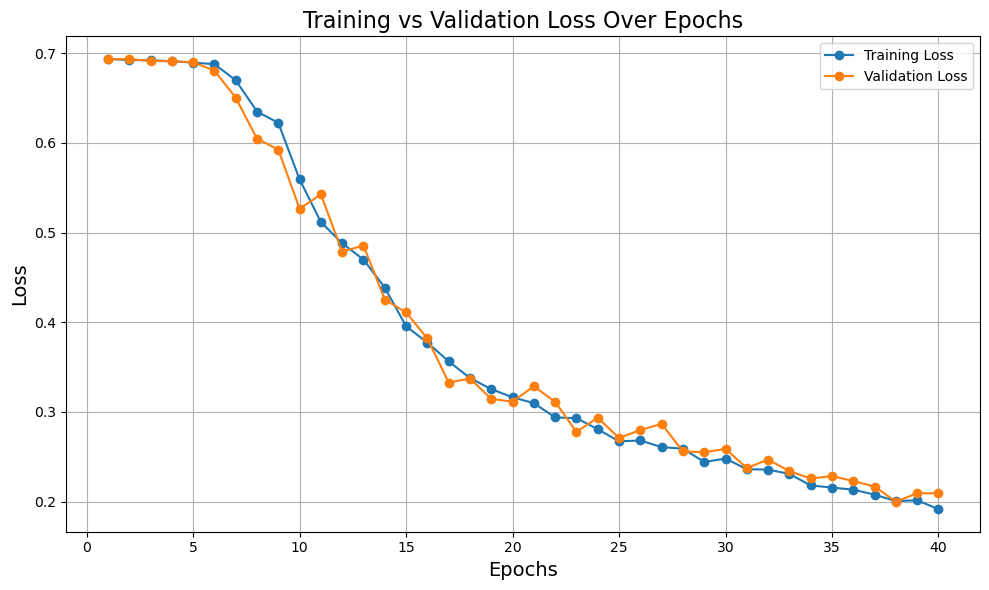

In [54]:
loss_values = [0.6937, 0.6924, 0.6921, 0.6911, 0.6895, 0.6878, 0.6698, 0.6350, 0.6223, 0.5593, 
 0.5117, 0.4881, 0.4699, 0.4387, 0.3956, 0.3773, 0.3565, 0.3378, 0.3255, 0.3163, 
 0.3099, 0.2939, 0.2931, 0.2808, 0.2673, 0.2682, 0.2608, 0.2591, 0.2442, 0.2481, 
 0.2362, 0.2358, 0.2309, 0.2181, 0.2157, 0.2134, 0.2078, 0.2007, 0.2015, 0.1916]

val_loss_values = [0.6931, 0.6935, 0.6913, 0.6910, 0.6899, 0.6806, 0.6504, 0.6047, 0.5926, 0.5266, 
 0.5425, 0.4788, 0.4856, 0.4253, 0.4110, 0.3820, 0.3328, 0.3373, 0.3146, 0.3115, 
 0.3287, 0.3113, 0.2778, 0.2936, 0.2710, 0.2799, 0.2867, 0.2561, 0.2551, 0.2588, 
 0.2375, 0.2469, 0.2340, 0.2259, 0.2285, 0.2230, 0.2169, 0.2000, 0.2094, 0.2093]

name = "first_balanced"

plot_loss(loss_values,val_loss_values,name)
